The purpose of this report is to display the charts for each of the 69 character pairs audited by both the graduate students and the automated process.

In [2]:
import IPython.display
import pandas as pd

audCompare = (
    pd.read_excel('CharacterSelectionforAutomatedProcess20190301.xlsx',
                  usecols="F,G",
                  names=['Pairs','status'],
                  index_col=0
                 )
)
audCompare = audCompare.loc[audCompare['status'] == 'Replaced']

In [3]:
allData = pd.read_csv(
    'AllTangAudits-3-1-19.csv',
    header=None,
    names=['Original','Modified','Chapter','Paragraph','StartLoc','Username']
)

In [4]:
import IPython.display
import pandas as pd
import numpy as np

# The initial variable holding pairs of characters being analyzed,
# as well as the dictionaries that will be used to contain DataFrames
# related to each pair of characters. Those DataFrames will then be
# used to display the results of each function.

characterPairs = audCompare.index
group = {} # Referenced in function: pairImport
userCounts = {} # Referenced in function: metricCounts
mutualChap = {} # Referenced in function: sharedChap

def sharedChap(i):
    '''Generate table of audited chapters shared between
    server and students.'''
    
    # The auditGroup DataFrame contains counts of audits per 
    # both chapter and user.
    
    auditGroup = (
        group[i].groupby(['Chapter','Username']).size()
        .reset_index(name='audit counts')
    )

    # The uniqueUsers list contains the names of users who submitted
    # audits for a particular pair of characters (group).
    # If the first user in the list is not "server," the values are
    # swapped to accommodate for displaying the automated process
    # first in all reports.
    
    uniqueUsers = group[i].Username.unique().tolist()
    
    if uniqueUsers[0] != 'server':
        a = uniqueUsers.index('server')
        uniqueUsers[0], uniqueUsers[a] = uniqueUsers[a], uniqueUsers[0]

    # The splitGroup dictionary holds DataFrames containing the audit
    # counts and chapters for a specific user.
    
    splitGroup = {}
    k = 0
    
    for u in uniqueUsers:
        splitGroup[k] = (
            auditGroup.loc[auditGroup['Username'] == u]
            [['Chapter','audit counts']]
        )
        k += 1

    # The merged dictionary holds DataFrames that are merged with
    # inner join to throw away any rows that are not shared between
    # the server and the user's list of audited chapters.
    
    merged = {}
    m = 1
    empClear = 0 # In case of an empty Dataframe, add to this number.
    
    while ( m < k ):
        merged[m - empClear] = (
            splitGroup[0].merge(
                splitGroup[m], 
                on='Chapter', 
                suffixes=(
                    '_{}'.format(uniqueUsers[0]),
                    '_{}'.format(uniqueUsers[m])
                )
            )
            .set_index('Chapter')
        )

        if merged[m - empClear].empty:
            del merged[m - empClear]
            empClear += 1

        m += 1
        
    # The mutualChap dictionary is then filled with the group's
    # concatenated DataFrame with all user's audits counts compared
    # with the server's own list, producing the desired report.
    # All NaN's are replaced with zeroes, converted to integers,
    # and then replaced with blank values for easier visibility.
    if len(merged) != 0:
        while ( m > 1 ):
            m -= 1
            mutualChap[i] = (
                pd.concat(merged, sort=False)
                .fillna(0)
                .astype(int)
            )
        # The resulting dictionary entry is then displayed to the user.
        #display(mutualChap[i])
    else:
        mutualChap[i] = []

def metricCounts(i):
    '''Generate counts of chapters and audits per user.'''
    
    # The userCounts dictionary is assigned a DataFrame that includes
    # counts of each audited chapter per user, and total number of
    # audits per user, with appropriate column labels.
    
    userCounts[i] = (
        group[i]
        .groupby(['Chapter','Username'])['Paragraph'].agg('count')
        .reset_index(name='audit count')
        .groupby('Username')['audit count'].agg(['count','sum'])
        .rename(index=str,
                columns={'count':'chapter count', 'sum':'audit count'}
               )
    )
    
    # A new row is added to the DataFrame to display the percentage
    # of chapters audited by users, and of users' combined audits.
    
    userCounts[i].loc['% of Total'] = (0.0)
    userCounts[i].loc['% of Total'].at['chapter count'] = (
        (
            userCounts[i].iloc[1:,0].sum()
            / group[i].Chapter.nunique()
        )
        .round(3) * 100
    )
    userCounts[i].loc['% of Total'].at['audit count'] = (
        (
            userCounts[i].iloc[1:,1].sum()
            / userCounts[i].loc[:,'audit count'].sum()
        )
        .round(3) * 100
    )
    
    # The resulting dictionary entry is then displayed to the user.
    
    #display(userCounts[i])

def pairImport(i):
    '''Import the appropriate CSV file to the group dictionary.'''

    char1 = audCompare.index[i].split('-')[0]
    char2 = audCompare.index[i].split('-')[1]
    
    group[i] = allData.loc[
        (allData['Original'] == char1) 
        & (allData['Modified'] == char2)
    ].reset_index(drop = True)

In [5]:
# For producing charts the following modules are imported.
    
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from math import ceil
%matplotlib inline

prop = fm.FontProperties(
    fname = '../Chinese Fonts/Exported Fonts'\
    '/LiHei Pro/LiHeiPro.ttf', size=20
)

def chartGroup (i):
    '''Generate swarmplots for chapters with a significant 
    number of mutual audits.'''

    if len(mutualChap[i]) != 0:

        # Reserve the column and user name for the server, to be used
        # in all generated charts.

        sColumnName = mutualChap[i].columns[0]
        sName = sColumnName.split('_', 1)[1]

        # Save the total number of columns (users) to a variable.

        columnCount = len(mutualChap[i].columns)

        # Set the initial plot parameters and title.

        fig = plt.figure(figsize=(columnCount * 2, 4))
        fig.suptitle(
            f'Excessiveness Test Group {i + 1}: {characterPairs[i]}', 
            y = 1.05, 
            fontproperties = prop
        )
        fig.text(0.5, 0, 'usernames', ha='center')

        # This loop creates a separate chart for each user in
        # comparison to the server.

        for x in range(1, columnCount):

            # The column and user name is reserved as their own variables.

            uColumnName = mutualChap[i].columns[x]
            uName = uColumnName.split('_', 1)[1]

            # Take the data of the server and the current user to be charted
            # to its own variable.

            charted = (mutualChap[i].loc[x][[sColumnName,uColumnName]]
                      .rename(index=str, columns={sColumnName: sName,
                                                  uColumnName: uName})
                      )

            # Draw the subplots and label y axis if first.

            ax = plt.subplot(1, columnCount-1, x)
            if x == 1:
                ax.set_ylabel('count of audits')
            sns.swarmplot(data = charted)

            # For y-axis ticks, determine the maximum number of audits
            # for the charted pair, then divide by 10 and round up to
            # an integer to set its interval. Also add that number to the
            # maximum number to buffer the padding at the top of the chart.

            sMax = mutualChap[i].loc[x].max()[0]
            uMax = mutualChap[i].max()[x]
            maxValue = max(sMax, uMax)
            ceilMax = ceil(maxValue / 10)
            ax.set_yticks(
                np.arange(0, maxValue + ceilMax, ceilMax)
            )

            # In cases where the server replaced three or more characters
            # in a chapter, highlight the corresponding dots with a red box.

            if sMax > 3:
                rect = patches.Rectangle(
                    (-0.4, 3.5), 
                    width = 0.8, height = sMax - 2,
                    linewidth = 1, edgecolor = 'r', facecolor = 'none')
                ax.add_patch(rect)

        plt.tight_layout()
        plt.show()
        fig.clear()

    else:
        print(f'Nothing to report for pair {i+1}.')

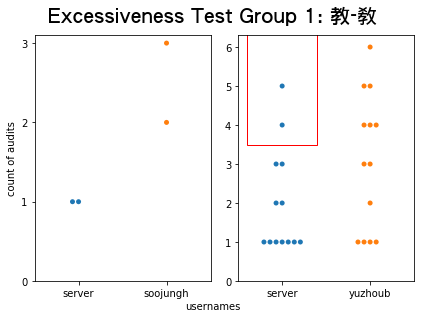

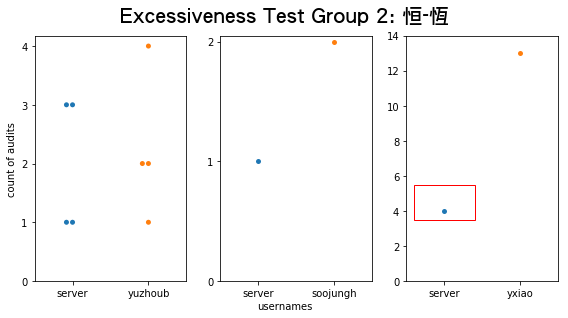

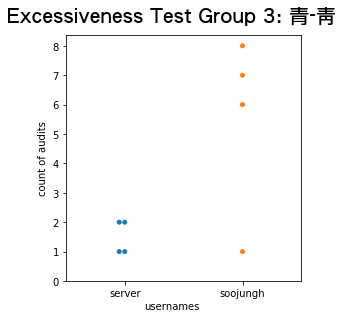

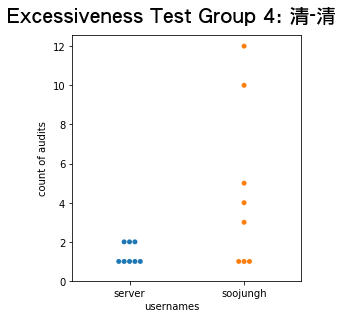

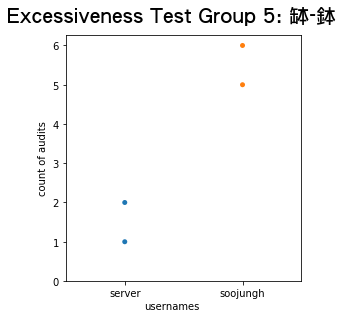

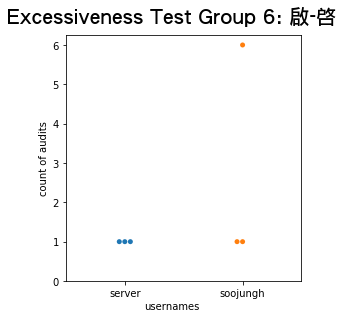

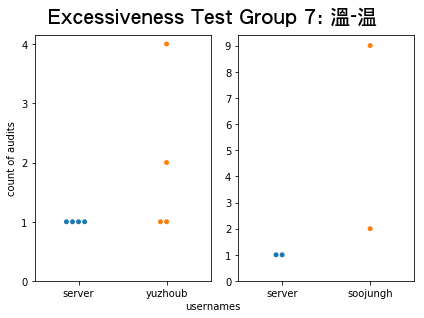

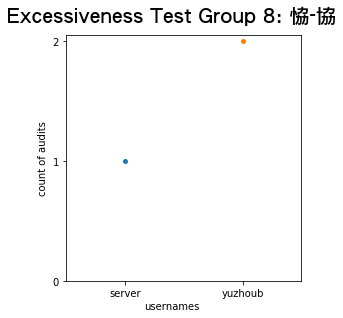

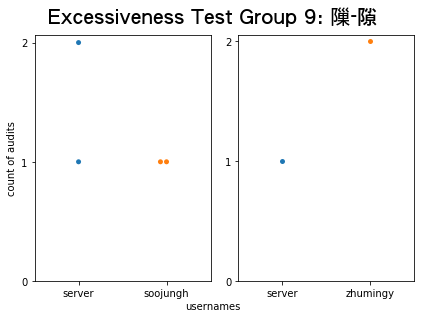

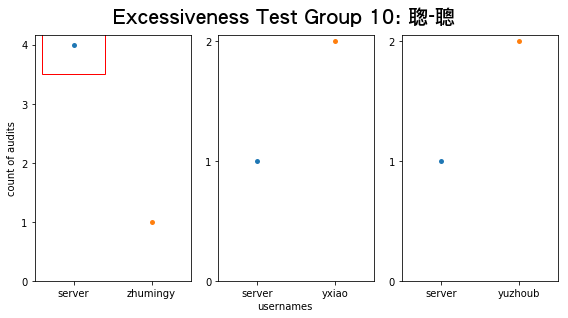

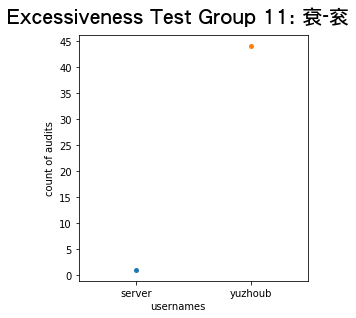

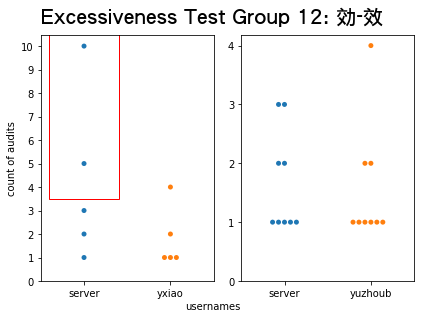

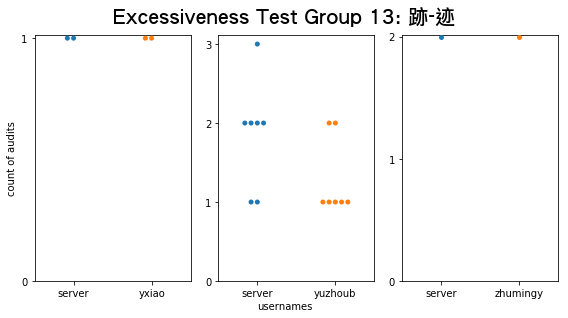

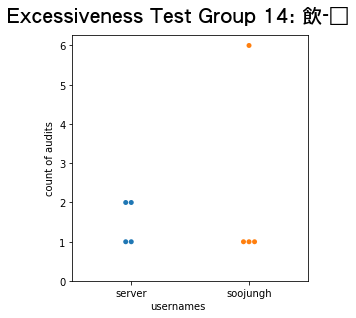

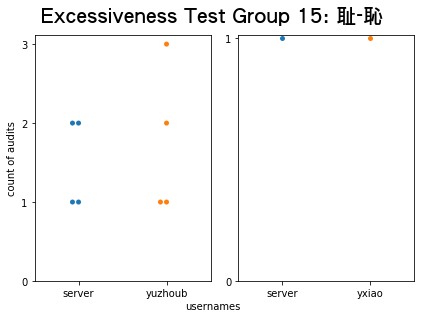

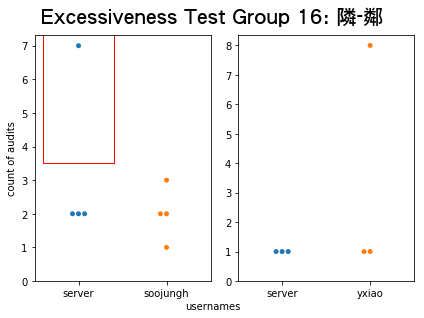

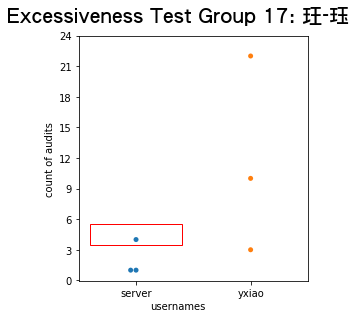

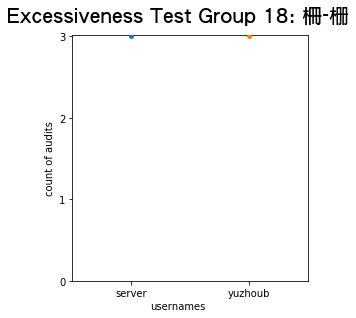

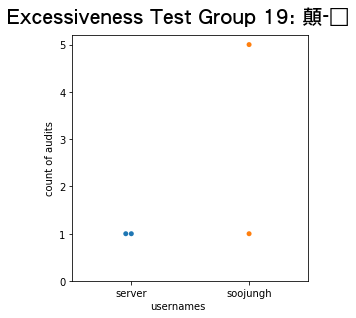

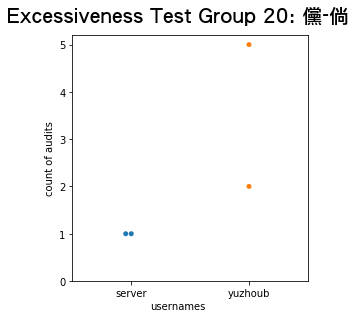

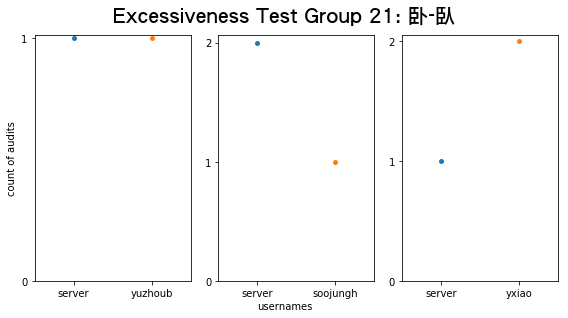

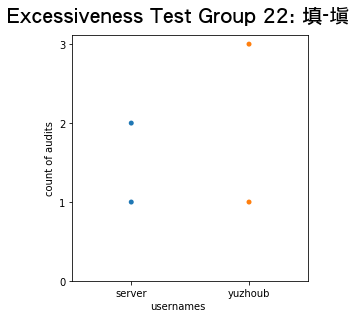

Nothing to report for pair 23.
Nothing to report for pair 24.
Nothing to report for pair 25.
Nothing to report for pair 26.
Nothing to report for pair 27.
Nothing to report for pair 28.
Nothing to report for pair 29.
Nothing to report for pair 30.
Nothing to report for pair 31.


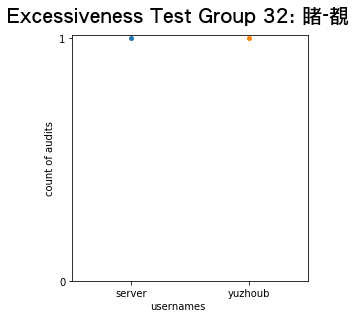

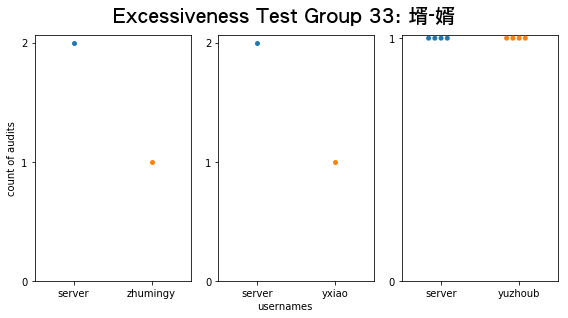

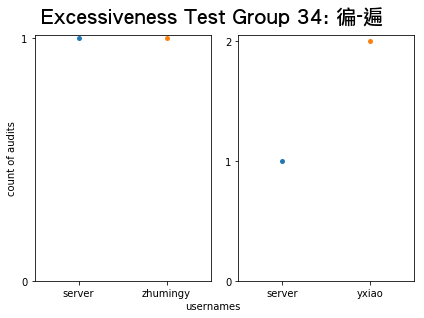

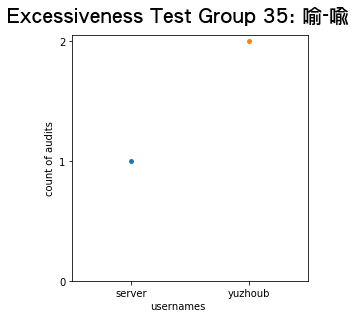

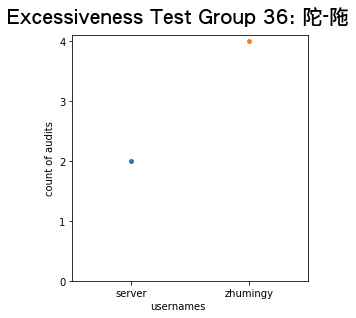

Nothing to report for pair 37.


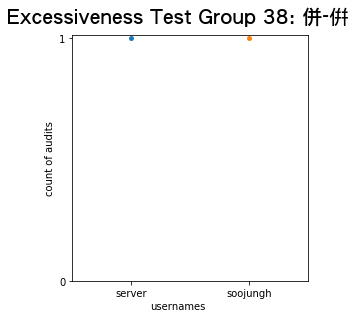

Nothing to report for pair 39.


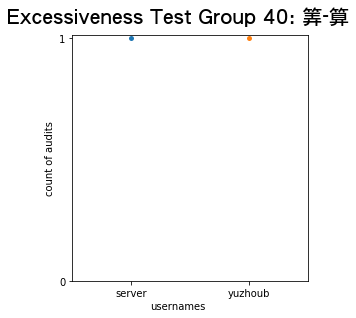

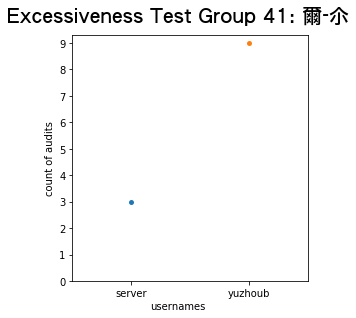

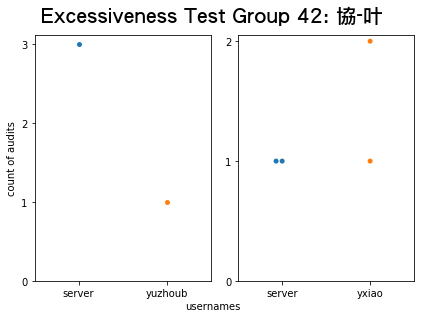

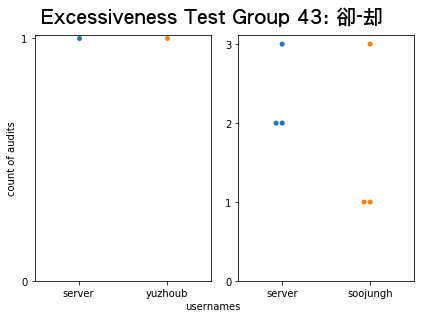

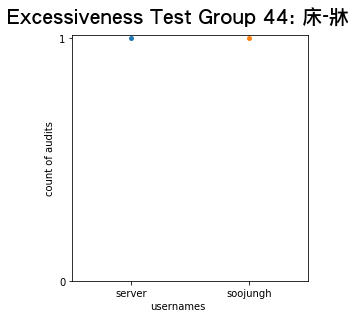

Nothing to report for pair 45.
Nothing to report for pair 46.
Nothing to report for pair 47.
Nothing to report for pair 48.


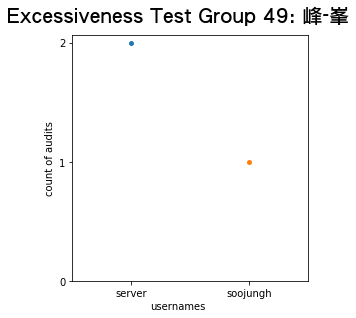

Nothing to report for pair 50.


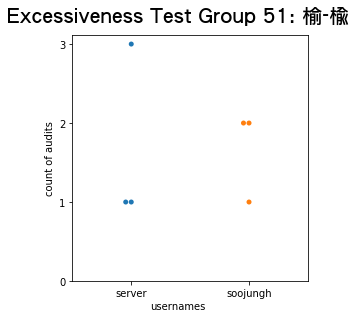

Nothing to report for pair 52.


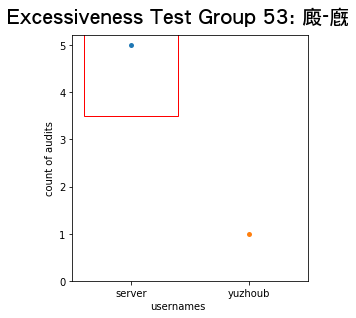

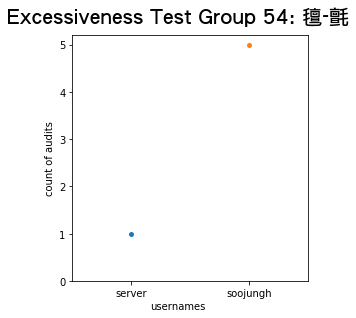

Nothing to report for pair 55.


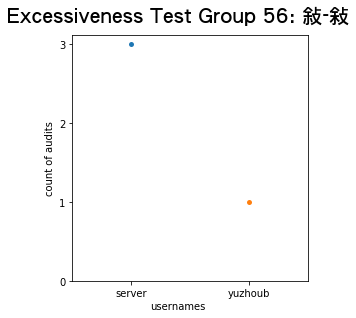

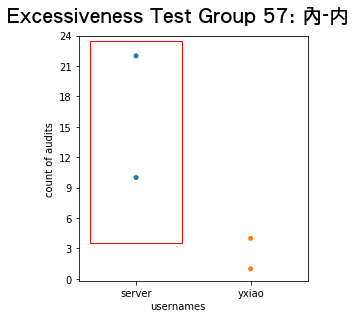

Nothing to report for pair 58.


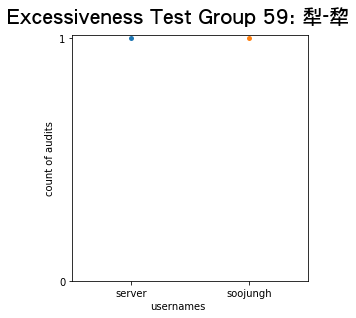

Nothing to report for pair 60.
Nothing to report for pair 61.
Nothing to report for pair 62.
Nothing to report for pair 63.
Nothing to report for pair 64.
Nothing to report for pair 65.
Nothing to report for pair 66.
Nothing to report for pair 67.
Nothing to report for pair 68.
Nothing to report for pair 69.


In [6]:
for i in range(0,len(audCompare.index)):
    pairImport(i)
    metricCounts(i)
    sharedChap(i)
    chartGroup(i)

In [7]:
test = allData.groupby(['Chapter','Paragraph','StartLoc']).count()
test = test.loc[test['Modified'] > 1]
test

Original  \
Chapter                                  Paragraph StartLoc             
JTS 051 — 卷五十一   列傳第一 后妃上                6         229              2   
                                         28        69               2   
JTS 052 — 卷五十二   列傳第二 后妃下                4         204              2   
                                         12        68               2   
                                         22        217              2   
                                         55        178              2   
JTS 053 — 卷五十三   列傳第三                    24        175              2   
JTS 056 — 卷五十六   列傳第六                    3         232              2   
JTS 057 — 卷五十七   列傳第七 裴寂                 3         239              2   
                                         16        172              2   
JTS 059 — 卷五十九   列傳第九 屈突通                42        172              2   
JTS 060 — 卷六十   列傳第十 宗室                  18        3                2   
                                         19        2                2   
                                         42        57               2   
                                         50        59               2   
                                         54        192              2   
JTS 061 — 卷六十一   列傳第十一 溫大雅               25        299              2   
                                         28        74               2   
                                         39        80               2   
JTS 062 — 卷六十二   列傳第十二 李綱                40        265              2   
JTS 063 — 卷六十三   列傳第十三 封倫                7         167              2   
JTS 066 — 卷六十六   列傳第十六                   8         57               2   
                                         30        480              2   
                                         32        26               2   
JTS 067 — 卷六十七   列傳第十七 李靖　李勣             17        23               2   
                                         40        11               2   
JTS 069 — 卷六十九   列傳第十九 侯君集　張亮　薛萬徹        17        156              2   
                                         24        222              2   
JTS 070 — 卷七十   列傳第二十 王珪　戴冑              12        131              2   
                                         40        81               2   
...                                                               ...   
JTS 198 — 卷一百九十八   列傳第一百四十八 西戎           27        92               2   
JTS 199b — 卷一百九十九下   列傳第一百四十九下 北狄        20        454              2   
JTS 200a — 卷二百上   列傳第一百五十上 安祿山           13        432              2   
XTS 082 — 卷八十二   列傳第七 十一宗諸子              134       3                2   
XTS 116 — 卷一百一十六   列傳第四十一                5         116              2   
XTS 119 — 卷一百一十九   列傳第四十四 武平一　李乂　賈曾至　白居易 17        38               2   
XTS 122 — 卷一百二十二   列傳第四十七 魏元忠　韋安石　郭元振    7         117              2   
                                         36        49               2   
                                         40        162              2   
                                         73        183              2   
XTS 123 — 卷一百二十三   列傳第四十八                4         374              2   
                                         21        61               2   
XTS 124 — 卷一百二十四   列傳第四十九 姚崇　宋璟          10        461              2   
XTS 125 — 卷一百二十五   列傳第五十 蘇瓌　張說           4         18               2   
                                         6         21               2   
                                                   30               2   
                                                   91               2   
                                         35        160              2   
                                         48        146              2   
XTS 126 — 卷一百二十六   列傳第五十一                43        442              2   
XTS 127 — 卷一百二十七   列傳第五十二 張嘉貞　源乾曜　裴耀卿    23        136              2   
XTS 129 — 卷一百二十九   列傳第五十四                23        106              2   
XTS 171 — 卷一百七十一   列傳第九十六                1    